# PART II 
# 4.  Fuzzy Clustering with Anomalous Patterns

## a) Study the fuzzy c-means (FCM) program in the software package of your choice.  
Apply the program to your dataset at the same hyperparameter c with random seeds. Do this for several 
different values c= c_min, ..., c_max.   Plot the FCM clustering criterion (FCM cost function) in function of 
c. Analyse the graphic and comment if any number of clusters better fits your data than the others. 

In [1]:
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd

data = pd.read_csv('Data_CC.csv')
data.drop(['CUST_ID'], axis=1, inplace=True)

# Since we have found multiple missing values, we decided to replace them with the mean of the column, since it is the most common method to deal with missing values and therefore should not affect the results of the analysis, being the most conservative approach.
data.fillna(data.mean(), inplace=True)
#normalize data with std dev
data_std = (data - data.mean()) / data.std()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

c_min = 2
c_max = 10
random_seeds = range(10)  # Or any range of random seeds you want to try


In [3]:
costs = []
fpc_ar=[]

for c in range(c_min, c_max + 1):
    cluster_costs = []
    for seed in random_seeds:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_std, c, m=2, error=0.005, maxiter=1000, seed=seed)
        
        cluster_costs.append(jm[-1])  # Appending the final cost
    costs.append(np.mean(cluster_costs))  # Taking the average cost across different random seeds
    fpc_ar.append(fpc)

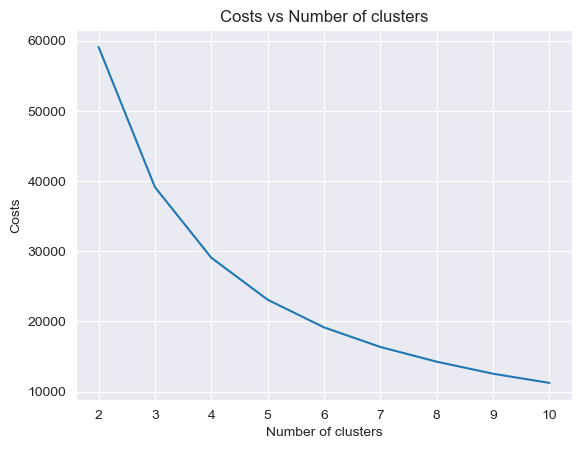

In [4]:
fig, ax = plt.subplots()
ax.plot(range(c_min, c_max + 1), costs)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Costs")
ax.set_title("Costs vs Number of clusters")
plt.show()

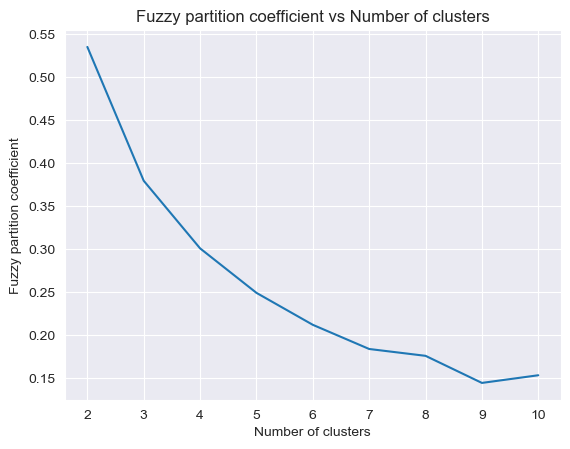

In [5]:
#plot fpc agasint number of clusters
fig, ax = plt.subplots()

ax.plot(range(c_min, c_max + 1), fpc_ar)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Fuzzy partition coefficient")
ax.set_title("Fuzzy partition coefficient vs Number of clusters")
plt.show()



### b) Study the (Iterative) Anomalous Pattern (IAP) clustering algorithm.

In [6]:
def center_(x, cluster):
    """ 
    calculates the centroid of the cluster
    x - the original data matrix ( N x d)
    cluster - the set with indices (i= 1, 2, ..., N) of the objects belonging to the cluster
    returns the centroid of the cluster 
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in cluster:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC


def distNorm(x ,remains, ranges, p):
    """ 
     Finds the normalized distances of data points in 'remains' to reference point 'p' 
     x - the original data matrix ( N x d)
     remains- the set of X-row indices: the indices of the entities under consideration
     ranges- the vector with the ranges of the data features  
     p - the reference data point the distances relate to
     distan- returns the column vetor  with the distances from p to remains 
     """

    
    mm = x.shape[1]      # number of data features
    rr = len(remains)    # number of entities in remains    
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))     # Construct an array by repeating input array np.array(p)  
                                           # the number of times given by (rr, 1)
    
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    distan = di
    return distan


def separCluster(x0, remains, ranges, a, b):
    """  
    Builds a cluster by splitting the points around the reference point 'a' from those around the reference point b 
    x0 - data matrix
    remains- the set of X-row indices: the indices of the entities under consideration
    ranges-  the vector with the ranges of the data features  
    a, b - the reference points
    cluster - returns a set with row indices of the objects belonging to the cluster  
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    cluster = []
    for i in clus:
        cluster.append(remains[i])
    return cluster


 ## Consult description of building an Anomalous cluster (lecture T3 - slide #57)
def anomalousPattern(x, remains, ranges, centroid, me):
    """ Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (B. Mirkin (1999): Machine Learning Journal) 
        x - data matrix,
        remains - the set of X-row indices: the indices of the entities under consideration
        ranges - normalizing values: the vector with ranges of data features  
        centroid - initial center of the anomalous cluster being build
        me - vector to shift the 0 (origin) to
        Returns a tuple with:
                cluster - set of (remains) row indices in the anomalous cluster, 
                centroid - center of the built anomalous cluster    
    """        
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
          
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ 
      Calculates the normalized distances of data points in 'remains' to reference point 'p'   
       x - data matrix,
       remains - the set of X-row indices: the indices of the entities under consideration
       ranges - normalizing values: the vector with ranges of data features      
       distan - returns the calculated normalized distances
    """

    
    mm = x.shape[1]       #number of columns
    rr = len(remains)     # number of entities in remains  
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j]         # j feature vector
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
    return distan

### c) Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the Anomalous Patterns_FCM to your data set

In [7]:
#PCA here
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#plot the PCA
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1)
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
# ax.grid()
# plt.show()



In [8]:
# normalization FLAG
normalization = 1
# threshold value of the cardinality of clusters (this is an example): 
threshold = 100

### I consider this from the PCA transformation
### Must be explored and adapted concerning the best normalization for specific data set
data_ap =  principalDf
x = data_ap.values.astype(np.float32)
#y = data.target

#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []

In [9]:
# loop over each feature
for j in range(mm):
    z = principalDf.iloc[:, j].values
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    

    if normalization:
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])

    if ranges [j] == 0:
        print("Variable num {} is constant!".format(j))
        ranges[j] = 1

# Normalized data
sy = np.divide((principalDf - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)  # Total data scatter of normalized data

In [10]:
remains = list(range(principalDf.shape[0]))
# Initialize lists to store clusters, centroids, and proportions
clusters_list = []
centroids_list = []
proportions_list = []

# Initialize the counter for anomalous clusters
numberC = 1

# Iterate until all data points are assigned to clusters
while len(remains) != 0:
    # Calculate distances from remaining data points to the reference point 'me'
    distance = dist(principalDf.values, remains, ranges, me)
    
    # Find the index of the data point with the maximum distance
    ind = np.argmax(distance)
    index = remains[ind]
    
    # Initialize the centroid as the data point with the maximum distance
    centroid = principalDf.iloc[index, :].values
    
    # Increment the counter for anomalous clusters
    numberC += 1
    
    # Find the cluster using the anomalous pattern algorithm
    (cluster, centroid) = anomalousPattern(principalDf.values, remains, ranges, centroid, me)
    
    # Calculate the standardized centroid with parameters of the data
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges))
    
    # Calculate the proportion of the data scatter contributed by the cluster
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))
    
    # Update the list of clusters, centroids, and proportions
    #check cluster shape before appending
    if len(cluster) > threshold:

        clusters_list.append(cluster)
        centroids_list.append(censtand)
        proportions_list.append(dD)
    
    # Update the set of remaining data points
    remains = np.setdiff1d(remains, cluster)


#associate the first array inside clusters_list with the first array inside centroids_list with the first value inside proportions_list
#and so on
ancl = list(zip(clusters_list, centroids_list, proportions_list)) #zip function ==> convert to list of tuples ! ancl[0] = (cluster0, centroid0, proportion0)


In [11]:
print(ancl)

[([6, 21, 23, 30, 48, 57, 71, 84, 86, 87, 90, 102, 109, 112, 120, 122, 125, 136, 138, 143, 144, 150, 151, 153, 154, 156, 158, 167, 171, 174, 178, 195, 196, 197, 204, 219, 220, 223, 224, 229, 242, 244, 248, 249, 258, 261, 262, 263, 265, 266, 269, 270, 273, 274, 280, 283, 290, 295, 301, 311, 312, 326, 329, 332, 333, 337, 341, 344, 348, 351, 355, 363, 370, 373, 376, 384, 393, 403, 415, 417, 423, 459, 461, 468, 477, 481, 484, 485, 487, 490, 492, 501, 507, 509, 511, 514, 524, 534, 536, 539, 544, 545, 546, 548, 550, 551, 560, 563, 565, 567, 574, 581, 584, 585, 587, 589, 591, 597, 609, 610, 616, 619, 620, 622, 624, 628, 629, 634, 642, 643, 644, 645, 647, 652, 655, 656, 658, 661, 662, 668, 669, 677, 690, 693, 698, 704, 708, 709, 712, 725, 726, 733, 749, 769, 771, 776, 782, 801, 806, 842, 844, 854, 856, 857, 861, 871, 883, 886, 889, 891, 895, 916, 917, 919, 926, 938, 941, 952, 970, 975, 982, 990, 991, 1012, 1053, 1059, 1061, 1087, 1118, 1125, 1137, 1150, 1176, 1190, 1193, 1218, 1226, 1240, 1242

In [12]:

num_clusters = 9 # Number of clusters obtained

# Initialize the initial partition array
init_partition = np.zeros((len(principalDf), num_clusters))

# Iterate over each tuple in ancl
for cluster_idx, (clusters, centroids, _) in enumerate(ancl):
    # Reshape centroids if needed
    #centroids = centroids.reshape((len(centroids), num_features))
    
    # Iterate over each data point in the cluster
    for data_idx in clusters:
        # Calculate distances from the data point to each centroid
        dists = [np.linalg.norm(principalDf.iloc[data_idx].values - c) for c in centroids]
        
        # Assign the data point to the nearest centroid
        assign = np.argmin(dists)
        
        # Update the initial partition array
        init_partition[data_idx, cluster_idx] = 1


In [13]:
num_clusters

9

In [19]:
# init_partition= init_partition.T
# #apply the fuzzy c-means algorithm considering the initial partition
# cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_std.T, 9, 2, error=0.005, maxiter=1000, init=init_partition)

# # Calculate the final partition
# cluster_membership = np.argmax(u, axis=0)

# # Initialize the final partition array
# final_partition = np.zeros((len(principalDf), num_clusters))

# # Iterate over each data point
# for data_idx, cluster_idx in enumerate(cluster_membership):
#     # Assign the data point to the corresponding cluster
#     final_partition[data_idx, cluster_idx] = 1

# # Calculate the final centroids
# final_centroids = cntr

# # Calculate the final partition matrix
# final_partition = final_partition.T

# # Calculate the final fuzzy partition coefficient
# final_fpc = fpc



In [ ]:
#initialize randomly the centroids
np.random.seed(42)
centroids = np.random.rand(num_clusters,2)


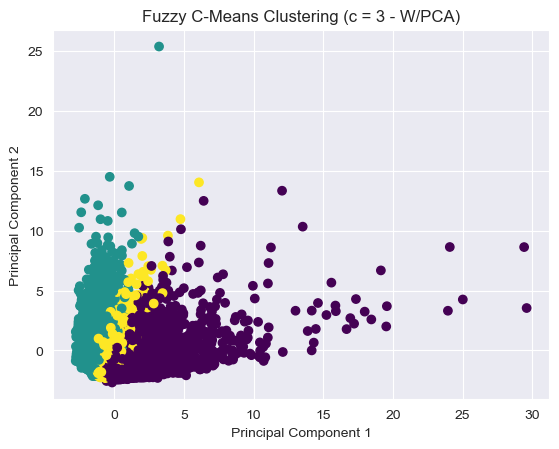

In [59]:
#apply fuzzy c means to the origial data and plot the clusters
cntr, u_orig, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_std.T, 3, 2, error=0.005, maxiter=1000)

# Calculate the final partition
cluster_membership = np.argmax(u_orig, axis=0)

# Initialize the final partition array
final_partition = np.zeros((len(principalDf), num_clusters))

# Iterate over each data point
for data_idx, cluster_idx in enumerate(cluster_membership):
    # Assign the data point to the corresponding cluster
    final_partition[data_idx, cluster_idx] = 1

# Calculate the final centroids
final_centroids = cntr

# Calculate the final partition matrix
final_partition = final_partition.T

# Calculate the final fuzzy partition coefficient
final_fpc = fpc

# Plot the clusters
fig, ax = plt.subplots()
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=cluster_membership, cmap='viridis')
#limit x and y


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Fuzzy C-Means Clustering (c = 3 - W/PCA)')


plt.show()


In [47]:
#calculate silloete score of the clusters
from sklearn.metrics import silhouette_score
silhouette_score(principalDf, cluster_membership)

print("Silhouette score: ", silhouette_score(principalDf, cluster_membership))

Silhouette score:  0.1278869001400593


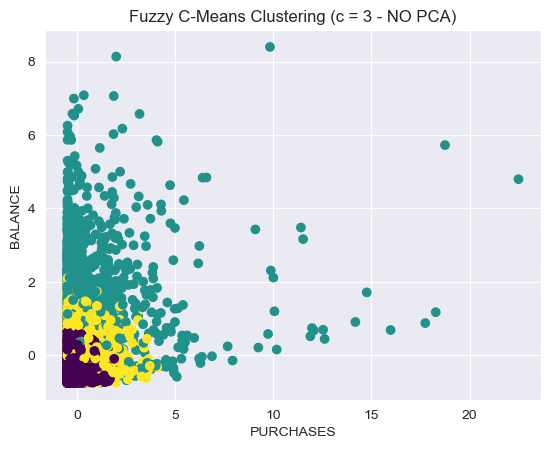

In [48]:
#apply fcm to teh data without pca
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, 3, 2, error=0.005, maxiter=1000)

# Calculate the final partition
cluster_membership = np.argmax(u, axis=0)

# Initialize the final partition array
final_partition = np.zeros((len(data_std), num_clusters))

# Iterate over each data point
for data_idx, cluster_idx in enumerate(cluster_membership):
    # Assign the data point to the corresponding cluster
    final_partition[data_idx, cluster_idx] = 1

# Calculate the final centroids
final_centroids = cntr

# Calculate the final partition matrix
final_partition = final_partition.T

# Calculate the final fuzzy partition coefficient
final_fpc = fpc

# Plot the clusters
fig, ax = plt.subplots()
ax.scatter(data_std['PURCHASES'], data_std['BALANCE'], c=cluster_membership, cmap='viridis')

ax.set_xlabel('PURCHASES')
ax.set_ylabel('BALANCE')
ax.set_title('Fuzzy C-Means Clustering (c = 3 - NO PCA)')


plt.show()


In [49]:
#calculate silloete score of the clusters
from sklearn.metrics import silhouette_score
silhouette_score(data_std, cluster_membership)


0.07841815852317865

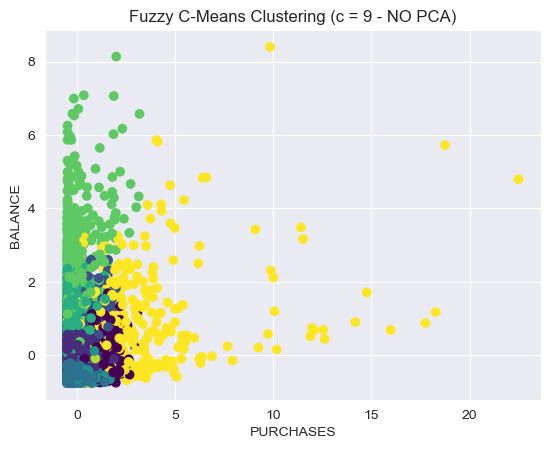

In [50]:
#apply fcm to teh data without pca
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, 9, 2, error=0.005, maxiter=15000
                                                )

# Calculate the final partition
cluster_membership = np.argmax(u, axis=0)

# Initialize the final partition array
final_partition = np.zeros((len(data_std), num_clusters))

# Iterate over each data point
for data_idx, cluster_idx in enumerate(cluster_membership):
    # Assign the data point to the corresponding cluster
    final_partition[data_idx, cluster_idx] = 1

# Calculate the final centroids
final_centroids = cntr

# Calculate the final partition matrix
final_partition = final_partition.T

# Calculate the final fuzzy partition coefficient
final_fpc = fpc

# Plot the clusters
fig, ax = plt.subplots()
ax.scatter(data_std['PURCHASES'], data_std['BALANCE'], c=cluster_membership, cmap='viridis')

ax.set_xlabel('PURCHASES')
ax.set_ylabel('BALANCE')
ax.set_title('Fuzzy C-Means Clustering (c = 9 - NO PCA)')


plt.show()


In [51]:
#calculate silloete score of the clusters
from sklearn.metrics import silhouette_score
silhouette_score(data_std, cluster_membership)


-0.004692127138609716

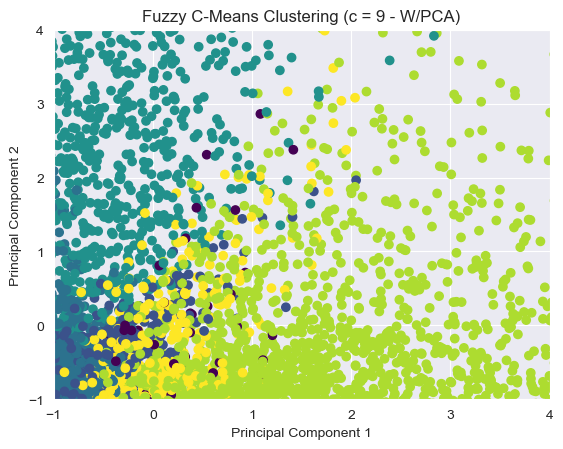

In [57]:
#apply fuzzy c means to the origial data and plot the clusters
cntr, u_orig, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_std.T, 9, 2, error=0.005, maxiter=15000)

# Calculate the final partition
cluster_membership = np.argmax(u_orig, axis=0)

# Initialize the final partition array
final_partition = np.zeros((len(principalDf), num_clusters))

# Iterate over each data point
for data_idx, cluster_idx in enumerate(cluster_membership):
    # Assign the data point to the corresponding cluster
    final_partition[data_idx, cluster_idx] = 1

# Calculate the final centroids
final_centroids = cntr

# Calculate the final partition matrix
final_partition = final_partition.T

# Calculate the final fuzzy partition coefficient
final_fpc = fpc

# Plot the clusters
fig, ax = plt.subplots()
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=cluster_membership, cmap='viridis')
#limit plot from -1 to 3
plt.xlim(-1,4)
plt.ylim(-1,4)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Fuzzy C-Means Clustering (c = 9 - W/PCA)')


plt.show()


In [53]:
#calculate silloete score of the clusters
from sklearn.metrics import silhouette_score
silhouette_score(principalDf, cluster_membership)


0.052801530066609564

Apply, at least, two validation indices, like the Adjust Rand Index (ARI) and Xie-Beni index, to access the
quality of the fuzzy c-partitions obtained in a). Compare these results with the one of Anomalous Patterns
FCM getting in c).

In [ ]:
#apply Xie-Beni index to find the optimal number of clusters

def xie_beni_index(data, u, cntr):
    n_clusters = cntr.shape[0]
    n_samples = data.shape[0]
    n_features = data.shape[1]
    xie_beni = 0
    for i in range(n_clusters):
        for j in range(n_samples):
            xie_beni += np.linalg.norm(data.iloc[j] - cntr[i]) ** 2 * u[i, j]
    min_dist = np.min(np.linalg.norm(cntr[:, None] - cntr, axis=2) + np.eye(n_clusters) * np.inf, axis=1)
    xie_beni /= n_samples * n_clusters * np.min(min_dist)
    return xie_beni

c_min = 2
c_max = 10
random_seeds = range(10)  # Or any range of random seeds you want to try

xie_beni = []
for c in range(c_min, c_max + 1):
    cluster_xie_beni = []
    for seed in random_seeds:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_std, c, m=2, error=0.005, maxiter=1000, seed=seed)
        cluster_xie_beni.append(xie_beni_index(data_std, u, cntr))
    xie_beni.append(np.mean(cluster_xie_beni))

fig, ax = plt.subplots()
ax.plot(range(c_min, c_max + 1), xie_beni)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Xie-Beni index")
ax.set_title("Xie-Beni index vs Number of clusters")
plt.show()
